In [1]:
import numpy as np
import decimal
import matplotlib.pyplot as plt
from scipy import interpolate as intp
from scipy import stats
import seaborn as sns
from itertools import compress
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import *
from scipy import signal
from scipy import stats
from scipy.signal import convolve as sig_convolve
from scipy.io import loadmat
from scipy.io import savemat
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import cv2
import time

import datajoint as dj

dj.config['database.host'] = 'at-database.ad.bcm.edu'
dj.config['database.user'] = 'raj'
dj.config['database.password'] = 'language-wonderful-joy-system'
dj.conn()

Connecting raj@at-database.ad.bcm.edu:3306


DataJoint connection (connected) raj@at-database.ad.bcm.edu:3306

In [2]:
from stimulus import stimulus
import datajoint as dj
tune=dj.create_virtual_module('tune','pipeline_tune')
GNN=dj.create_virtual_module('GNN', 'pipeline_GNN')
meso=dj.create_virtual_module('meso','pipeline_meso')

In [3]:
from neuro_data.movies import data_schemas
from neuro_data.movies.stats import load_dataset

/Users/rajdbz/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def Extract_Orientation_Contrast(frame, ksize, sigma_o, sigma_c, rs):
    """
    Function that estimates the local orientation and contrast at each pixel in the input image frame.
    Inputs:
    frame   - input image
    ksize   - kernel size of the gaussian kernel used to smooth the squared gradients
    sigma_o - standard deviation of the gaussian kernel for estimating orientations
    sigma_c - standard deviation of the gaussian kernel for estimating orientations
    rs      - factor by which to resize the gradient functions
    
    Outputs: 
    Ohat  - estimated orientation
    Chat  - estimated contrast
    """

    # First, compute the gradients
    gx = frame[:,1:] - frame[:,0:-1]
    gx = np.concatenate((gx,np.expand_dims(gx[:,-1],axis=1)),axis=1)

    gy = frame[1:,:] - frame[0:-1,:]
    gy = np.concatenate((gy,np.expand_dims(gy[-1,:],axis=0)),axis=0)

    gxx = gx**2
    gyy = gy**2
    gxy = gx*gy

    # smoothen these sqaured gradients if needed
    gxx = cv2.GaussianBlur(gxx,(ksize,ksize),sigma_o)
    gyy = cv2.GaussianBlur(gyy,(ksize,ksize),sigma_o)
    gxy = cv2.GaussianBlur(gxy,(ksize,ksize),sigma_o)

    # resize these gradient functions
    if rs != 1:
        gxx = cv2.resize(gxx,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)
        gyy = cv2.resize(gyy,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)
        gxy = cv2.resize(gxy,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)

    # Compute local orientations
    Ohat = np.zeros(gxx.shape)    
    Ohat = np.arctan2(gyy - gxx +((gyy-gxx)**2+(2*gxy)**2)**0.5, 2*gxy)
    
    # Align the orientation such that 0 radians is north, pi/2 is west and pi is south
    Ohat = np.mod(-Ohat,np.pi)

    Chat = np.sqrt(gx**2 + gy**2)
    Chat = cv2.GaussianBlur(Chat,(ksize,ksize),sigma_c)
    if rs != 1:
        Chat = cv2.resize(Chat,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)
    
    return Ohat, Chat

In [5]:
# define custom functions
def pick_indices(x,l,u):
    """
    Pick the elements of an array x that lie between l and u
    """
    id_s = np.nonzero(x >= l)[0]
    id_e = np.nonzero(x <= u)[0]
    return np.intersect1d(id_s,id_e)

def vonMisesFn(x,amp,scale,theta0):
    """
    Von Mises function, but for orientations
    x goes from (0, pi)
    """
    return amp*np.exp(scale*np.cos(2*(x-theta0)))

def expandN_dims(x,N):
    """
    Add N extra dimensions to x
    """
    dims = np.shape(x.shape)[0] 
    for i in range(N):
        x = np.expand_dims(x,axis=dims+i)
    return x

def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [6]:
# Load the data set: movies, neural responses, etc
key = (data_schemas.MovieMultiDataset.Member & 'group_id=9').fetch('KEY')
#key = (data_schemas.MovieMultiDataset.Member & 'group_id=1').fetch('KEY')
dset = load_dataset(key)
key

[{'animal_id': 16314,
  'group_id': 9,
  'pipe_version': 1,
  'preproc_id': 0,
  'scan_idx': 1,
  'segmentation_method': 3,
  'session': 3,
  'spike_method': 5}]

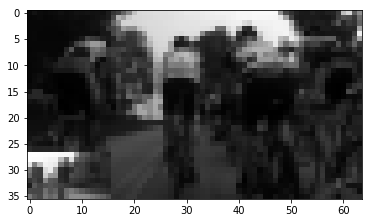

In [10]:
plt.imshow(dset[1].inputs[0,0],cmap='gray')

In [7]:
# No. of neurons in this scan
NNeuFull = len(dset.neurons.layer)
print('No. of neurons in this scan =', NNeuFull)

Neu_Layers = dset.neurons.layer # layer label of each neuron
Neu_Area = dset.neurons.area    # area label of each neuron

# No. of movie clips
Ns = len(dset)
print('No. of movie clips =', Ns)

# Size of the movie clips
print('Size of the movie clip =', dset[0].inputs.shape)

T, Ny, Nx = dset[0].inputs.shape[1:]

No. of neurons in this scan = 7067
No. of movie clips = 568
Size of the movie clip = (1, 300, 36, 64)


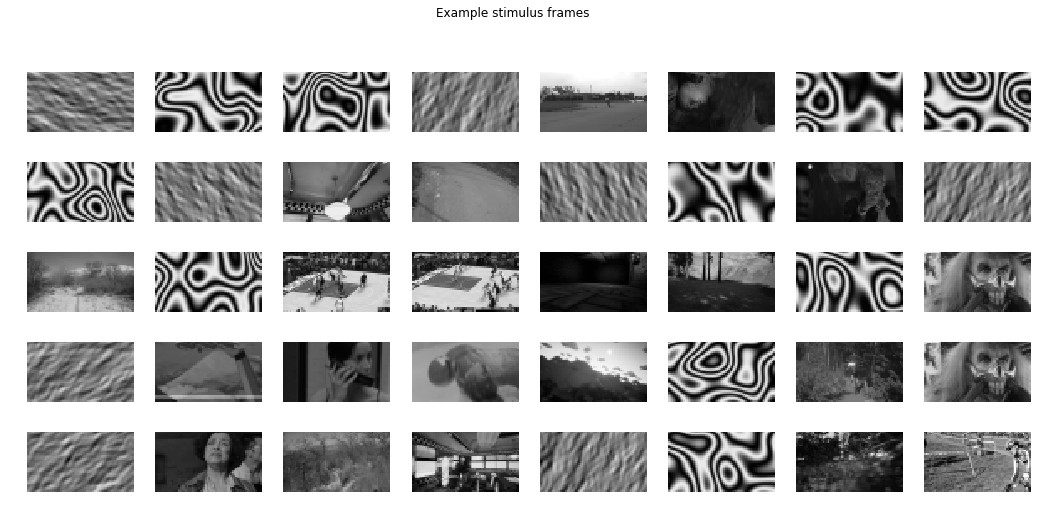

In [8]:
# Look at some sample stimulus images
plt.figure()
plt.subplots(5,8,figsize=(18,8))
plt.suptitle('Example stimulus frames')
for k in range(40):
    plt.subplot(5,8,k+1)
    plt.imshow(dset[np.random.randint(Ns)].inputs[0,0],vmin =0,vmax=255,cmap='gray')
    plt.axis('off')
plt.show()

In [9]:
# Find the unit_ids of the neurons
unit_ids = dset.neurons.unit_ids

In [10]:
# Next step, obtain the receptive fields of these neurons
tkeys, response_maps, rx, ry, snr = (tune.STA.Map() * tune.STAExtent() * tune.STAQual() & key).fetch(dj.key, 'map','x','y', 'snr',order_by='unit_id')

NNeu = len(tkeys)
RFs = np.zeros([NNeu,Ny,Nx])
RxVec = np.zeros([NNeu])
RyVec = np.zeros([NNeu])

for k in range(NNeu):
    RFs[k,:,:] = cv2.resize(np.float32(response_maps[k][:,:,1]),(Nx,Ny),interpolation = cv2.INTER_LANCZOS4)
    RxVec[k] = rx[k]*Nx/response_maps[k].shape[1]
    RyVec[k] = ry[k]*Ny/response_maps[k].shape[0]
    
RxVec = np.round(RxVec)
RyVec = np.round(RyVec)
    
# No. of neurons for which RFs were computed
NNeu = len(response_maps)
print('No. of neurons for which RFs were computed =', NNeu)

# Match the tkeys from RF computation with unit_ids
# Neu_RF_ids corrsponds to the indices of the neurons in responses for which RFs have been computed
Neu_RF_ids = np.zeros([NNeu],dtype='int')
for k in range(NNeu):
    Neu_RF_ids[k] = np.nonzero(unit_ids == tkeys[k]['unit_id'])[0]
    

No. of neurons for which RFs were computed = 1903


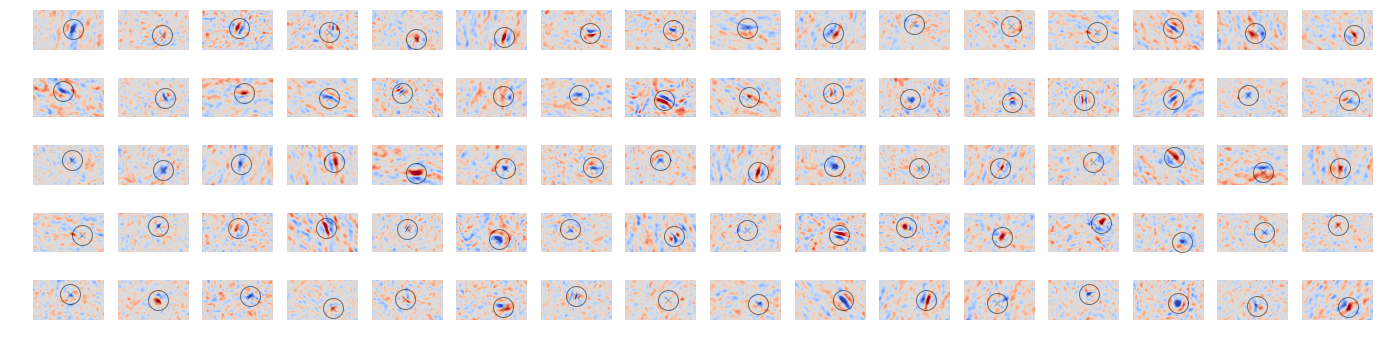

In [11]:
# Plot a few example RFs
MaxVec = np.zeros([NNeu])
MinVec = np.zeros([NNeu])
for i in range(NNeu):
    MaxVec[i] = np.max(response_maps[i])
    MinVec[i] = np.min(response_maps[i])

plt.figure()
plt.subplots(5,8,figsize=(24,6))
for k in range(80):
    plt.subplot(5,16,k+1)
    neu_idx = np.random.randint(NNeu)
    plt.imshow(response_maps[neu_idx][:,:,1],cmap = 'coolwarm',vmin = MinVec.mean(),vmax=MaxVec.mean())
    plt.plot(rx[neu_idx],ry[neu_idx],'o',markersize=20,mec='k',mfc="None",alpha = 0.5)
    plt.plot(rx[neu_idx],ry[neu_idx],'kx',alpha=0.25)
    plt.axis('off')
plt.show()

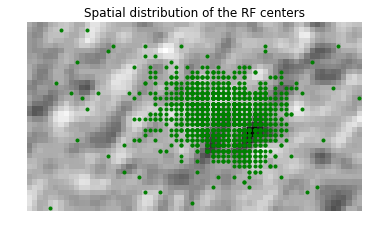

In [12]:
# Plot the distribution of the RF centers

plt.imshow(RFs[600],cmap = 'gray')
plt.plot(RxVec,RyVec,'g.')
plt.axis('off')
plt.title('Spatial distribution of the RF centers')
plt.show()

In [13]:
# Load the estimated local orientation and contrast variables for all the movie clips
data = loadmat('/Users/rajdbz/Reservoir/Code/Cajal-local/Dataset9/Estimated_features_Dataset9-ksize19.mat')
OhatFull = data['OhatFull']
ChatFull = data['ChatFull']
del data

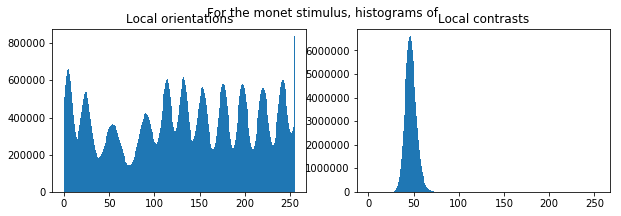

In [14]:
# We will use only the Monet clips for computing the Tuning curves
MonetId = np.nonzero((dset.types == 'stimulus.Monet2')*1)[0]
TrippyId = np.nonzero((dset.types == 'stimulus.Trippy')*1)[0]
ClipId = np.nonzero((dset.types == 'stimulus.Clip')*1)[0]

# Look at the histogram of the orientation and contrasts in Monet stimulus
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(10,3))
fig.suptitle('For the monet stimulus, histograms of')
ax[0].hist(OhatFull[MonetId].flatten(),np.arange(256))
ax[0].set_title('Local orientations')
ax[1].hist(ChatFull[MonetId].flatten(),np.arange(256))
ax[1].set_title('Local contrasts')
plt.show()

In [15]:
# Quantize the Orientations. We do this to compute tuning curves by binning
Nbins_o = 11 #no. of orientation bins

# In Monet the orientation is pretty much the same throughout each frame
OhatMonet_q = np.uint8(np.floor(OhatFull[MonetId]*(Nbins_o/256.0))) 
OhatMonet_q = np.mean(OhatMonet_q,axis=2)
OhatMonet_q = np.mean(OhatMonet_q,axis=2)
OhatMonet_q = np.uint8(np.round(OhatMonet_q))

In [16]:
# Compute tuning curves by binning
TuningCurves_All = np.zeros([len(MonetId), NNeu, Nbins_o]) # No. of Monet stimulus clips x No. of neurons x No. of orientation bins

BinCounts = np.zeros([len(MonetId),Nbins_o])

for ss in range(len(MonetId)):
    for ii in range(Nbins_o):
        idx_o = np.nonzero(OhatMonet_q[ss,:] == ii)[0]
        BinCounts[ss,ii] = len(idx_o)
        TC = np.sum(dset[MonetId[ss]].responses[idx_o,:],axis=0)
        TuningCurves_All[ss,:,ii] = TC[Neu_RF_ids]
        
del OhatMonet_q

In [17]:
BinCounts = np.sum(BinCounts,axis=0)
BinCounts = np.expand_dims(BinCounts,axis=0)

TuningCurves_All = np.sum(TuningCurves_All,axis=0)/BinCounts

In [18]:
# Compute Von Mises fits to tuning curves
# We assume tuning curves are of the form A*exp(k.cos(x-x_pref))

AmpVec = np.zeros([NNeu])   # Amplitude of von mises function
KVec = np.zeros([NNeu])    # Concentration parameter
ThetaVec = np.zeros([NNeu]) # Preferred orientation

ori_set = (2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o

init_vals = [1, 1, np.pi/2]     # for [amp, scale, theta0]
lb = [0,0,0]
ub = [10,10,np.pi]

for k in range(NNeu):
    best_vals, covar = curve_fit(vonMisesFn, ori_set, TuningCurves_All[k,:], p0=init_vals,bounds=(lb,ub))
    AmpVec[k] = best_vals[0]
    KVec[k] = best_vals[1]
    ThetaVec[k] = best_vals[2]


In [19]:
# compute the quality of the von mises fits
FitErr = np.zeros([NNeu])
for k in range(NNeu):
    A = AmpVec[k]
    K = KVec[k]
    Th = ThetaVec[k]
    vfit = vonMisesFn(ori_set,A,K,Th)
    fsc = TuningCurves_All[k,:]
    # normalize both the curves the max of fsc
    vfit = vfit/fsc.max()
    fsc = fsc/fsc.max()
    FitErr[k] = np.sum((vfit - fsc)**2)


In [20]:
# """
# sort the neurons according to the quality of these fits
# """

# sortidx = np.argsort(FitErr)

# theta = np.linspace(0,np.pi,100)

# plt.figure()
# N = 5
# M = 4
# f2, axes2 = plt.subplots(N,2*M,figsize=(22,10))

# for ax, k in zip(axes2,np.arange(N)): 
#     for m in range(M):
#         nidx = sortidx[M*k+m]
#         # nidx = np.random.randint(NNeu)

#         rmap = response_maps[nidx][:,:,1]
#         ax[2*m].imshow(rmap,cmap='coolwarm',vmin=MinVec.mean(),vmax=MaxVec.mean())
#         ax[2*m].plot(rx[nidx],ry[nidx],'o',markersize=24,mec='k',mfc="None",alpha = 0.5)
#         ax[2*m].axis('off')

#         A = AmpVec[nidx]
#         K = KVec[nidx]
#         Th = ThetaVec[nidx]
#         vfit = vonMisesFn(theta,A,K,Th)
#         fsc = TuningCurves_All[nidx,:]

#         ax[2*m+1].plot((2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o,fsc,'k.-')
#         ax[2*m+1].plot(np.linspace(0,np.pi,100),vfit)
#         ax[2*m+1].axes.set_xlim((0,np.pi))
#         ax[2*m+1].axes.set_ylim((0,fsc.max()+2))
#         ax[2*m+1].set_xticks([])


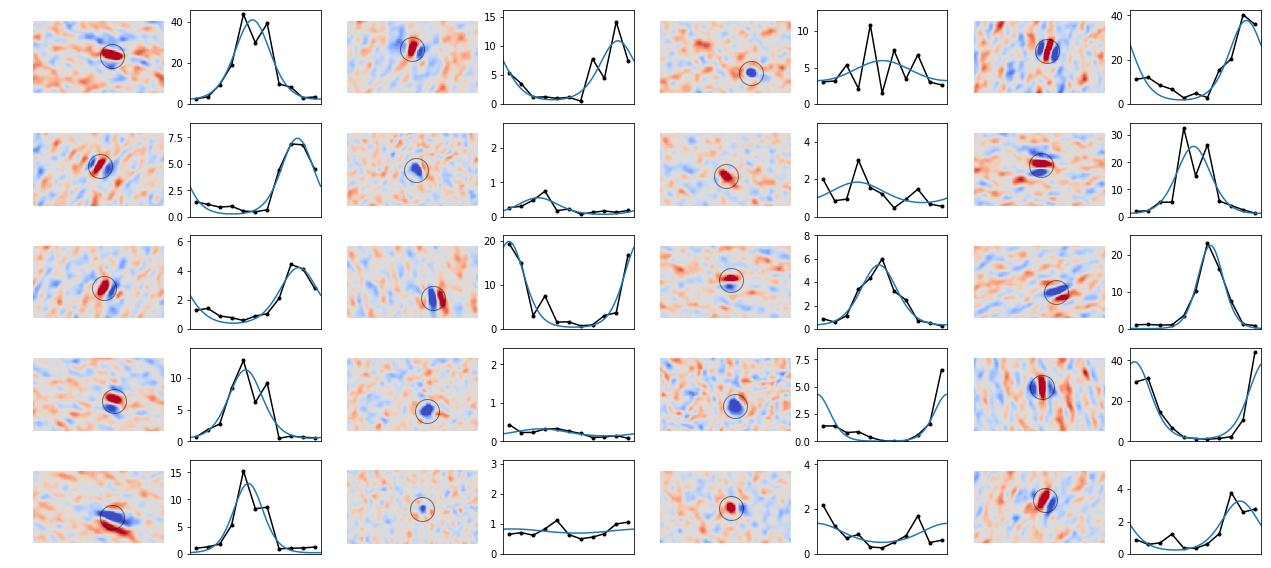

In [21]:
# plot tuning curves of neurons with the best receptive fields
sortidx = np.argsort(-snr)

plotTuningCurves = 1

theta = np.linspace(0,np.pi,100)


if plotTuningCurves:
    N = 5
    M = 4
    f2, axes2 = plt.subplots(N,2*M,figsize=(22,10))
    
    for ax, k in zip(axes2,np.arange(N)): 
        for m in range(M):
            nidx = sortidx[M*k+m]
            # nidx = np.random.randint(NNeu)
            
            rmap = response_maps[nidx][:,:,1]
            ax[2*m].imshow(rmap,cmap='coolwarm',vmin=MinVec.mean(),vmax=MaxVec.mean())
            ax[2*m].plot(rx[nidx],ry[nidx],'o',markersize=24,mec='k',mfc="None",alpha = 0.5)
            ax[2*m].axis('off')
            
            A = AmpVec[nidx]
            K = KVec[nidx]
            Th = ThetaVec[nidx]
            vfit = vonMisesFn(theta,A,K,Th)
            fsc = TuningCurves_All[nidx,:]
            
            ax[2*m+1].plot((2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o,fsc,'k.-')
            ax[2*m+1].plot(np.linspace(0,np.pi,100),vfit)
            ax[2*m+1].axes.set_xlim((0,np.pi))
            ax[2*m+1].axes.set_ylim((0,fsc.max()+2))
            ax[2*m+1].set_xticks([])
            


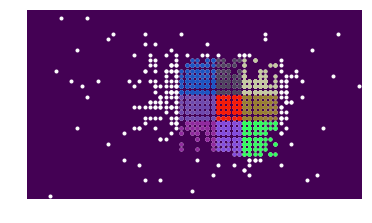

[242. 248. 111. 175. 258. 169. 116. 230. 153.]


In [22]:
# Build the populations
"""
Construct the PPCs based on RF centers of the neurons
"""

X_C = np.int(np.round(RxVec.mean()))
Y_C = np.int(np.round(RyVec.mean()))

id_PPC = []

# Pick a Mx x My grid of groups(Mx and My should be odd)
# Each individual group is itself a MxM grid of pixels
M = 5
Mx = 3
My = 3
Mxb2 = np.int((Mx-1)/2)
Myb2 = np.int((Mx-1)/2)
Mb2 = np.int((M-1)/2)

x0 = X_C - Mb2 -M*Mxb2
y0 = Y_C - Mb2 -M*Myb2

x0 = x0 + 1 #adding offset based on manual observation

PopulationCenters = np.zeros([Mx*My,2])

N_populations = 0

for ix in range(Mx):
    if ix == 0:
        id_x = pick_indices(RxVec,x0 + ix*M-2, x0 + (ix+1)*M - 1)
    elif ix == Mx-1:
        id_x = pick_indices(RxVec,x0 + ix*M, x0 + (ix+1)*M + 1)
    else:
        id_x = pick_indices(RxVec,x0 + ix*M, x0 + (ix+1)*M - 1)       
    for iy in range(My):
        if iy == 0:
            id_y = pick_indices(RyVec,y0 + iy*M-2, y0 + (iy+1)*M - 1)
        elif iy == My -1:
            id_y = pick_indices(RyVec,y0 + iy*M, y0 + (iy+1)*M + 1)
        else:
            id_y = pick_indices(RyVec,y0 + iy*M, y0 + (iy+1)*M - 1)
        id_PPC.append(np.intersect1d(id_x,id_y))
        PopulationCenters[N_populations,0] = x0 + ix*M + Mb2
        PopulationCenters[N_populations,1] = y0 + iy*M + Mb2
        N_populations = N_populations + 1
        
# plot the RF centers and show grouping of the PPCs
plt.figure()
plt.imshow(np.zeros([Ny,Nx]))
plt.plot(np.round(RxVec),np.round(RyVec),'w.')
for i in range(N_populations):
    plt.plot(np.round(RxVec[id_PPC[i]]),np.round(RyVec[id_PPC[i]]),color=tuple(np.random.rand(3)),marker='.',linestyle='None')
    
plt.axis('off')
plt.show()

# Find the no. of neurons in each population
NNeu_Pops = np.zeros([N_populations])
for i in range(len(id_PPC)):
    NNeu_Pops[i] = len(id_PPC[i])

print(NNeu_Pops)


In [23]:
# Compute the feedforward responses of the neurons

FF_Activity = np.zeros([Ns,NNeu,T])

MeanContrast = np.round(ChatFull[MonetId].mean()) #assume linear contrast function, normalized to mean contrast for Monet stimulus

for nn in range(NNeu):
    px = np.int(RxVec[nn])
    py = np.int(RyVec[nn])
    FF_Activity[:,nn,:] = (ChatFull[:,:,py,px]/MeanContrast)*vonMisesFn(OhatFull[:,:,py,px]*np.pi/256.,AmpVec[nn],KVec[nn],ThetaVec[nn])
    


In [24]:
# Compute the cos and sin statistics for feedforward and actual neural responses

FF_cos = np.zeros([Ns,N_populations,T])
FF_sin = np.zeros([Ns,N_populations,T])

R_cos = np.zeros([Ns,N_populations,T])
R_sin = np.zeros([Ns,N_populations,T])

AverageNeuronsinPPC = np.mean(NNeu_Pops)

normalizeByNNeu = 1 #if you want to scale the number of neurons in each population to the average across populations

# Add extra dimensions to Theta and K 
ThetaVec_E = expandN_dims(ThetaVec,2)
ThetaVec_E = ThetaVec_E.transpose([1,0,2])
KVec_E = expandN_dims(KVec,2)
KVec_E = KVec_E.transpose([1,0,2])

for ii in range(len(id_PPC)):
    idx = id_PPC[ii]
    ThetaPPC = ThetaVec_E[:,idx,:]
    KPPC = KVec_E[:,idx,:]
    
    if normalizeByNNeu:
        Z = len(idx)/AverageNeuronsinPPC
    else:
        Z = 1
        
    FF_cos[:,ii,:] = np.sum(FF_Activity[:,idx,:]*KPPC*np.cos(2*ThetaPPC),axis=1)/Z
    FF_sin[:,ii,:] = np.sum(FF_Activity[:,idx,:]*KPPC*np.sin(2*ThetaPPC),axis=1)/Z
    
    
    for ss in range(Ns):
        R_cos[ss,ii,:] = np.sum((dset[ss].responses[0:T,Neu_RF_ids[idx]].T)*KPPC[0]*np.cos(2*ThetaPPC[0]),axis=0)/Z
        R_sin[ss,ii,:] = np.sum((dset[ss].responses[0:T,Neu_RF_ids[idx]].T)*KPPC[0]*np.sin(2*ThetaPPC[0]),axis=0)/Z
    
    

In [25]:
print(np.corrcoef(FF_cos[MonetId,:,:].flatten(),R_cos[MonetId,:,:].flatten())[0,1])
print(np.corrcoef(FF_cos[TrippyId,:,:].flatten(),R_cos[TrippyId,:,:].flatten())[0,1])
print(np.corrcoef(FF_cos[ClipId,:,:].flatten(),R_cos[ClipId,:,:].flatten())[0,1])

0.6002841445561299
0.358461080705932
0.24268051584697975


In [26]:
print(np.corrcoef(FF_sin[MonetId,:,:].flatten(),R_sin[MonetId,:,:].flatten())[0,1])
print(np.corrcoef(FF_sin[TrippyId,:,:].flatten(),R_sin[TrippyId,:,:].flatten())[0,1])
print(np.corrcoef(FF_sin[ClipId,:,:].flatten(),R_sin[ClipId,:,:].flatten())[0,1])

0.6070511158695527
0.37098104878342636
0.11152906191926547


In [27]:
# mdict = {'R_cos': R_cos, 'R_sin': R_sin, 'FF_cos': FF_cos, 'FF_sin': FF_sin}
# fname = './PopulationStatisticsData_DataSet9.mat'
# savemat(fname, mdict)

In [28]:
# Compute correlation coefficient for each population separately
CosCorr = np.zeros([N_populations,3])
SinCorr = np.zeros([N_populations,3])

for i in range(N_populations):
    CosCorr[i,0] = np.corrcoef(FF_cos[MonetId,i,:].flatten(),R_cos[MonetId,i,:].flatten())[0,1]
    CosCorr[i,1] = np.corrcoef(FF_cos[TrippyId,i,:].flatten(),R_cos[TrippyId,i,:].flatten())[0,1]
    CosCorr[i,2] = np.corrcoef(FF_cos[ClipId,i,:].flatten(),R_cos[ClipId,i,:].flatten())[0,1]
    
    SinCorr[i,0] = np.corrcoef(FF_sin[MonetId,i,:].flatten(),R_sin[MonetId,i,:].flatten())[0,1]
    SinCorr[i,1] = np.corrcoef(FF_sin[TrippyId,i,:].flatten(),R_sin[TrippyId,i,:].flatten())[0,1]
    SinCorr[i,2] = np.corrcoef(FF_sin[ClipId,i,:].flatten(),R_sin[ClipId,i,:].flatten())[0,1]
        
        

In [29]:
# finding oracles
# uniquehashes, u_idx = np.unique(dset.condition_hashes, return_index=True)
# NRepsVec = np.zeros([len(uniquehashes)])
# for i in range(len(NRepsVec)):
#     NRepsVec[i] = np.sum((dset.condition_hashes == uniquehashes[i])*1)
    
# idx = np.nonzero(NRepsVec > 1)[0]
# NRepsVec[idx]
# dset.types[u_idx[idx[0]]]

In [30]:
TrippyResponses = np.zeros([len(TrippyId),T,NNeu])
for ss in range(len(TrippyId)):
    TrippyResponses[ss,:,:] = dset[TrippyId[ss]].responses[:,Neu_RF_ids]

In [31]:
Nbins_c = 11 #no. of contrast bins

OhatTrippy_q = np.uint8(np.floor(OhatFull[TrippyId]*(Nbins_o/256.0))) 

ChatTrippy_q = np.uint8(np.floor(ChatFull[TrippyId]*(Nbins_c/256.0))) 



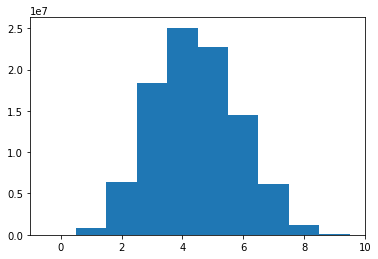

In [32]:
plt.hist(ChatTrippy_q.flatten(),np.arange(Nbins_c)-0.5)
plt.show()

In [33]:
# now to build 2D tuning curves  using the Trippy stimulus

TuningCurves_2D = np.zeros([NNeu, Nbins_c, Nbins_o]) # No. of Monet stimulus clips x No. of neurons x No. of orientation bins

BinCounts = np.zeros([NNeu, Nbins_c, Nbins_o])

t_st = time.time()

for nn in range(NNeu):
    
    R_nn = TrippyResponses[:,:,nn].flatten() #responses of neuron nn
    
    # receptive field centers of neuron nn
    px = np.int(RxVec[nn])
    py = np.int(RyVec[nn])
    
    for ii in range(Nbins_c):
        
        idx_c = np.nonzero(ChatTrippy_q[:,:,py,px].flatten() == ii)[0] #find indices where contrast = ii
        
        for jj in range(Nbins_o):
            
            idx_o = np.nonzero(OhatTrippy_q[:,:,py,px].flatten() == jj)[0] #find indices where orientation = jj
            idx_oc = np.intersect1d(idx_c, idx_o)  # intersection of contrast and orientation bin
            
            BinCounts[nn,ii,jj] = len(idx_oc)
            
            TuningCurves_2D[nn,ii,jj] = np.sum(R_nn[idx_oc])

t_en = time.time()
print('Time elapsed =',t_en - t_st)

TuningCurves_2D = TuningCurves_2D[:,2:8,:]/BinCounts[:,2:8,:] #ignore the extreme contrast bins
#TuningCurves_2D = TuningCurves_2D[:,1:5,:]/BinCounts[:,1:5,:] #ignore the extreme contrast bins

Time elapsed = 75.7867488861084


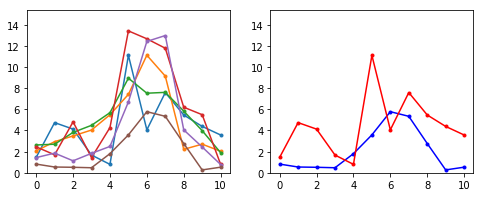

In [34]:
nidx = sortidx[11]
fig, ax= plt.subplots(1,2,figsize=(8,3))
ax[0].plot(TuningCurves_2D[nidx].T,'.-')
ax[0].axes.set_ylim((0,TuningCurves_2D[nidx].max()+2))
ax[1].plot(TuningCurves_2D[nidx,5,:],'b.-')
ax[1].plot(TuningCurves_2D[nidx,0,:],'r.-')
ax[1].axes.set_ylim((0,TuningCurves_2D[nidx].max()+2))
plt.show()

In [35]:
MaxContrastBin = np.argmax(TuningCurves_2D.max(axis=2),axis=1)

331
169
157
207
294
745


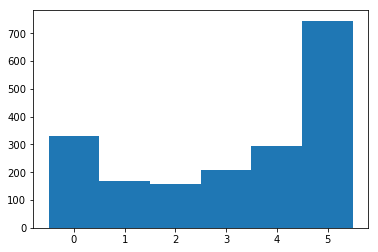

In [36]:
for i in range(6):
    print(len(np.nonzero(MaxContrastBin == i)[0]))
plt.hist(MaxContrastBin,np.arange(7)-0.5)
plt.show()

In [37]:
np.sum((dset.neurons.area[Neu_RF_ids] == 'V1')*1)

1588

In [38]:
np.sum((dset.neurons.area[Neu_RF_ids] == 'LM')*1)

315

In [39]:
id_LC = np.nonzero(MaxContrastBin == 0)[0]
print('LM neurons with low contrast preference =',np.sum((dset.neurons.area[Neu_RF_ids[id_LC]] == 'LM')*1))
print('V1 neurons with low contrast preference =',np.sum((dset.neurons.area[Neu_RF_ids[id_LC]] == 'V1')*1))

id_HC = np.nonzero(MaxContrastBin == 5)[0]
print('LM neurons with high contrast preference =',np.sum((dset.neurons.area[Neu_RF_ids[id_HC]] == 'LM')*1))
print('V1 neurons with high contrast preference =',np.sum((dset.neurons.area[Neu_RF_ids[id_HC]] == 'V1')*1))

LM neurons with low contrast preference = 79
V1 neurons with low contrast preference = 252
LM neurons with high contrast preference = 104
V1 neurons with high contrast preference = 641
